<a href="https://colab.research.google.com/github/patrikrac/NLP_SQuAD2.0/blob/main/ATML_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Topics in Machine Learning - Natural Language Processing -- Group Assignment
> Students
> - Patrik Rác
> - Méline Trochon
> - Valentina Moretti
> - Mattia Colbertaldo

---



In this notebook we:

* investigate the dataset and calculate and visualise statistics for the collection.

* finetune a pretrained DistilBERT model (from HuggingFace's transformers library) on the Squadv2 dataset for question answering.

* train a Word2Vec embedding on the documents and investigate its properties.

* evaluate the model on the test set and save the model and the tokenizer for later use.

* create a retrieval-based chatbot that can identify both impossible and certain answers

* create a chatbot that uses the model to answer questions about the dataset.

* implement text to speech and speech to text to make the chatbot more interactive.

* fine tune of the model on the speeech to text task on our voice

* implement an UI to record our voice and then predict the text that is used by the chatbot

* costumize the chatbot to our voice by fine tuning it on our voice

* repeat the process using the fine tuned Distilbert on SquadV2 dataset using a pre-indexed Wikipedia dataset.

* implement few shot learning by using a T5 generative model.



This notebook is designed to be run on a the SquadV2 dataset.

The preprocessing steps of the dataset used to create the embeddings are custom to the dataset.

In [1]:
! pip install datasets transformers accelerate -U
! pip install sentencepiece
! pip install --upgrade gensim

In [1]:
# Imports
import os
import torch
import pandas

import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric

## 1. Investigate Dataset


We will investigate the dataset ***SQuAD2.0 (Stanford Question Answering Dataset)*** avaliable [here](https://rajpurkar.github.io/SQuAD-explorer/).

In [2]:
# Download the dataset
print("Downloading the dataset of SQuAD2.0")
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

--2024-01-13 10:32:16--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json.2’

train-v2.0.json.2   100%[===================>]  40.17M   216MB/s    in 0.2s    

2024-01-13 10:32:17 (216 MB/s) - ‘train-v2.0.json.2’ saved [42123633/42123633]



Read the dataset using pandas library from the json file

In [3]:
import pandas
dataframe = pandas.read_json("./train-v2.0.json")
print(f"Size of the dataset: {dataframe.size} (e.g. Categories of questions)")
dataframe.head()

Size of the dataset: 884 (e.g. Categories of questions)


,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


We count the number of paragraphs, questions and impossible questions

In [4]:
def count_paragraphs(row):
    return len(row["data"]["paragraphs"])

print(f"Number of individual paragraphs: {sum(dataframe.apply(count_paragraphs, axis=1))}")


def count_questions(row):
  return sum([len(p["qas"]) for p in row["data"]["paragraphs"]])

print(f"Number of individual questions: {sum(dataframe.apply(count_questions, axis=1))}")

def count_impossible_questions(row):
  n_impossible = 0
  for p in row["data"]["paragraphs"]:
    for q in p["qas"]:
      if q["is_impossible"]:
        n_impossible += 1
  return n_impossible


print(f"Number of impossible questions: {sum(dataframe.apply(count_impossible_questions, axis=1))}")

Number of individual paragraphs: 19035
Number of individual questions: 130319
Number of impossible questions: 43498


Print the dataset

In [5]:
print(type(dataframe.iloc[0]["data"]))

import json
print(json.dumps(dataframe.iloc[1]["data"], sort_keys=False, indent=4))

<class 'dict'>
{
    "title": "Fr\u00e9d\u00e9ric_Chopin",
    "paragraphs": [
        {
            "qas": [
                {
                    "question": "What was Fr\u00e9d\u00e9ric's nationalities?",
                    "id": "56cbd2356d243a140015ed66",
                    "answers": [
                        {
                            "text": "Polish and French",
                            "answer_start": 182
                        }
                    ],
                    "is_impossible": false
                },
                {
                    "question": "In what era was Fr\u00e9d\u00e9ric active in?",
                    "id": "56cbd2356d243a140015ed67",
                    "answers": [
                        {
                            "text": "Romantic era",
                            "answer_start": 276
                        }
                    ],
                    "is_impossible": false
                },
                {
                    "q

Print the example of a Paragraph and a question to understand the structure of the dataset

In [6]:
import textwrap
print("Category of given paragraph: {}\n".format(dataframe.iloc[0]["data"]["title"]))

example_datum = dataframe.iloc[0]["data"]["paragraphs"][0]
print("Context\n {}\n".format(textwrap.fill(example_datum["context"], 50)))

print("Example Question:\n{}\n".format(example_datum["qas"][0]["question"]))

print("Example Answer:\n{}\n".format(example_datum["qas"][0]["answers"][0]["text"]))

Category of given paragraph: Beyoncé

Context
 Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-
YON-say) (born September 4, 1981) is an American
singer, songwriter, record producer and actress.
Born and raised in Houston, Texas, she performed
in various singing and dancing competitions as a
child, and rose to fame in the late 1990s as lead
singer of R&B girl-group Destiny's Child. Managed
by her father, Mathew Knowles, the group became
one of the world's best-selling girl groups of all
time. Their hiatus saw the release of Beyoncé's
debut album, Dangerously in Love (2003), which
established her as a solo artist worldwide, earned
five Grammy Awards and featured the Billboard Hot
100 number-one singles "Crazy in Love" and "Baby
Boy".

Example Question:
When did Beyonce start becoming popular?

Example Answer:
in the late 1990s



We will now create a list with pairs (Title, Question, Paragraph, Answers).

This will be useful for the next steps of the tutorial where we will use the HuggingFace datasets library

In [7]:
data_list = list()
categories = list()
paragraphs = list()
questions = list()

for _, row in dataframe.iterrows():
  categories.append(row["data"]["title"])
  for p in row["data"]["paragraphs"]:
    paragraphs.append(p["context"])
    for q in p["qas"]:
      questions.append(q["question"])
      data_list.append((row["data"]["title"], q, p["context"], q["answers"]))

Plot the number of paragraphs length distribution

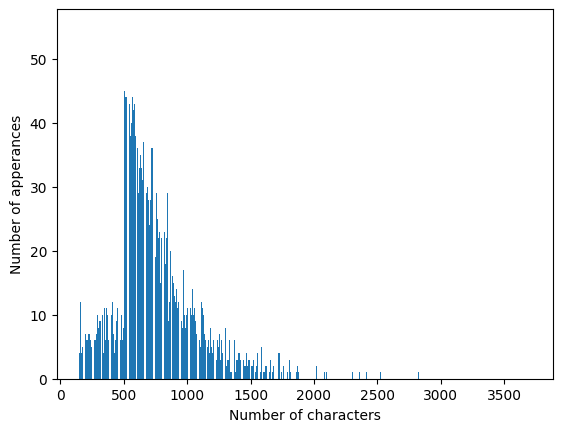

In [8]:
paragraph_len_dict = dict()
for p in paragraphs:
  lp = len(p)
  if lp not in paragraph_len_dict:
    paragraph_len_dict[lp] = 1
  else:
    paragraph_len_dict[lp] += 1

plt.bar(paragraph_len_dict.keys(), paragraph_len_dict.values(), align='center')
plt.xlabel("Number of characters")
plt.ylabel("Number of apperances")
#plt.savefig("len_distribution.png")
plt.show()

## 2. Training Word2Vec

In this section we train a word2vec model on the paragraphs of the SQuAD dataset.

We remove the email addresses and newline characters from the paragraphs and split them into sentences.

In [ ]:
# Load the nessecary libraries
import re

# remove newline characters
paragraphs_w2v = [re.sub('\n', ' ', p) for p in paragraphs]
# remove email addresses
paragraphs_w2v = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', p) for p in paragraphs_w2v]
# split sentences
paragraph_sentences = [re.split('[?!.]\s', p) for p in paragraphs_w2v]
paragraph_sentences[:3]

[['The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France',
  'They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia',
  'Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia',
  'The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.'],
 ['The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East',
  'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Ca

Flatten the sentences using the flatten function from pandas in order to get a list of sentences

In [ ]:
from pandas.core.common import flatten
paragraph_sentences = list(flatten(paragraph_sentences))
paragraph_sentences[:20]

['The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France',
 'They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia',
 'Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia',
 'The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East',
 'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic 

We obtain the tokenized sentences of the paragraph by splitting on whitespace, removing punctuation and converting to lowercase

In [ ]:
# Preprocess the sentences (very simple tokenization)
paragraph_tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in paragraph_sentences]
# remove sentences that are only 1 word long
paragraph_tokenized_sentences = [sentence for sentence in paragraph_tokenized_sentences if len(sentence) > 1]

for sentence in paragraph_tokenized_sentences[:10]:
    print(sentence)
print()
print(f"Number of tokenized sentences = {len(paragraph_tokenized_sentences)}")

['the', 'normans', 'norman', 'nourmands', 'french', 'normands', 'latin', 'normanni', 'were', 'the', 'people', 'who', 'in', 'the', '10th', 'and', '11th', 'centuries', 'gave', 'their', 'name', 'to', 'normandy', 'a', 'region', 'in', 'france']
['they', 'were', 'descended', 'from', 'norse', 'norman', 'comes', 'from', 'norseman', 'raiders', 'and', 'pirates', 'from', 'denmark', 'iceland', 'and', 'norway', 'who', 'under', 'their', 'leader', 'rollo', 'agreed', 'to', 'swear', 'fealty', 'to', 'king', 'charles', 'iii', 'of', 'west', 'francia']
['through', 'generations', 'of', 'assimilation', 'and', 'mixing', 'with', 'the', 'native', 'frankish', 'and', 'roman', 'gaulish', 'populations', 'their', 'descendants', 'would', 'gradually', 'merge', 'with', 'the', 'carolingian', 'based', 'cultures', 'of', 'west', 'francia']
['the', 'distinct', 'cultural', 'and', 'ethnic', 'identity', 'of', 'the', 'normans', 'emerged', 'initially', 'in', 'the', 'first', 'half', 'of', 'the', '10th', 'century', 'and', 'it', 'c

Train the word2vec model on the tokenized sentences. 

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(paragraph_tokenized_sentences, vector_size=30, min_count=5, window=10)

len(model.wv)

3998

### Inspection of the W2V embedding

Now we inspect the word vectors to access if the model is working as expected

In [ ]:
term = 'car'
model.wv[term]

array([ 0.04057898, -0.00312986,  0.17986928,  0.07059216,  0.04381702,
        0.08370378,  0.22301102,  0.03001559, -0.11262328,  0.0514932 ,
        0.09641131,  0.0892488 , -0.04129973, -0.14210753, -0.00300549,
       -0.11222779,  0.00609669, -0.07083324, -0.22837777, -0.0841409 ,
        0.03065133,  0.00296772,  0.02482023,  0.17426671,  0.09259891,
        0.05354922,  0.05035822,  0.09622449, -0.12108433, -0.20909923],
      dtype=float32)

As

As we can see, the closest words to the word 'king' are not really related to the word 'king'.


In [ ]:
term = 'king'
model.wv.most_similar(term)

[('with', 0.9987552165985107),
 ('from', 0.9986580610275269),
 ('on', 0.998618483543396),
 ('american', 0.9985692501068115),
 ('through', 0.9985644817352295),
 ('study', 0.9984967708587646),
 ('modern', 0.9984954595565796),
 ('upper', 0.998436450958252),
 ('national', 0.99842768907547),
 ('de', 0.9984264969825745)]

The operation on the vectors is not givung us the expected result.

In [ ]:
vec = model.wv['king'] + (model.wv['woman'] - model.wv['man'])
model.wv.similar_by_vector(vec)

[('england', 0.9981468319892883),
 ('american', 0.9981021285057068),
 ('architecture', 0.9980552196502686),
 ('king', 0.9980142712593079),
 ('chinese', 0.9977939128875732),
 ('building', 0.9977544546127319),
 ('under', 0.9977461695671082),
 ('black', 0.9977372288703918),
 ('his', 0.9977056980133057),
 ('price', 0.9976696372032166)]

## 3. Finetuning DistilBERT

In [9]:
# Import the transformers package (We'll be taking a pretrained model from here)
!pip install transformers
import transformers
# print(transformers.__version__)

We define the pretrained model we want to use. In this case we are using the _base_ _uncased_ variant of ***DistilBert***. Additionally we are fixing the batch size.

In [10]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

Load the dataset. Here we can go down two distinct routes that will not have a particularly large impact on the next steps.
1. Use the already prepared ***SQuAD2.0*** dataset from huggingface using the _load_dataset_ method.
2. Transform the prepared data from above into a similar dataset class

The first step is significantly easier and is therefore used, however, even with the second approach there are no major difficulties as the data is already present in a prepared format. We could then just use the already predefined split or use the huggingface funciton _train_test_split()_ in order to split the data.

For the first approach we additionally reduce the size of the training set as we want to achieve the fine tuning in a reasonable time frame. We thus select a random (fixed seed) subset of 20_000 items.

In [11]:
squad2_datasets = load_dataset("squad_v2") # Possibly replace the huggingface prepared dataset with the custom loaded one...
print(squad2_datasets)
# Reduce the size of the training data set by selecting a random subsample
# squad2_datasets["train"] = squad2_datasets["train"].shuffle(seed=42).select(range(20000))
# print(squad2_datasets)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


We then import the tokenizer that was used to pretrain the given model as we will also use it. For this reason we import the _AutoTokenizer_ class from _transformers_ and use its method _from_pretrained_.

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We can now simply test the tokenizer on a sample question/paragrpah and see what happens!

In [13]:
sample_IDX = 1
switched_vocab = {v: k for k, v in tokenizer.vocab.items()}

# Example with a Question
sample_question = squad2_datasets["train"][sample_IDX]["question"]
print(f"The sample question is: ''{sample_question}''")
print(f"The tokenized question is: {tokenizer(sample_question).input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenizer(sample_question).input_ids])
print()

# Example with a Paragraph
sample_paragraph = squad2_datasets["train"][sample_IDX]["context"]
print(f"The sample context is: ''{sample_paragraph}''")
print(f"The tokenized context is: {tokenizer(sample_paragraph).input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenizer(sample_paragraph).input_ids])
print()

# Complete example (Question + Context)
tokenization_example_complete = tokenizer(sample_question, sample_paragraph)
print(f"The tokenized example is: {tokenization_example_complete.input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenization_example_complete.input_ids])
print()

print("Vocabulary size: ", len(tokenizer.vocab))

The sample question is: ''What areas did Beyonce compete in when she was growing up?''
The tokenized question is: [101, 2054, 2752, 2106, 20773, 5566, 1999, 2043, 2016, 2001, 3652, 2039, 1029, 102]
token values:  ['[CLS]', 'what', 'areas', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?', '[SEP]']

The sample context is: ''Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 nu

In [14]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [15]:
pad_on_right = tokenizer.padding_side == "right"

In [16]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [17]:
from datasets import load_dataset
tokenized_datasets = squad2_datasets.map(prepare_train_features, batched=True, remove_columns=squad2_datasets["train"].column_names)

### Actual Fine Tuning of the Model

In [18]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

# model_path = "/content/test-squad-trained_full.zip"
#
# if os.path.exists(model_path):
#  # Unzip the model file
#  ! unzip "/content/test-squad-trained_full"
#  model = AutoModelForQuestionAnswering.from_pretrained("/content/content/test-squad-trained").to(device)
#  print("Loaded the already finetuned model. Do not run the training loop!")
#else:
#  model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to(device)
#  print("Loaded a not finetuned checkpoint of Huggingface. Please run training loop!")
#

model = AutoModelForQuestionAnswering.from_pretrained("patrikrac/test-squad-trained_full").to(device)

In [20]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

In [21]:
from transformers import default_data_collator

data_collator = default_data_collator

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Skip this if the finetuned model is already loaded.  
Jump to the section evaluation!

##### Training (skip in most cases)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.221600,1.278445
2,0.922400,1.235207
3,0.731500,1.440542


TrainOutput(global_step=24705, training_loss=1.09187263962808, metrics={'train_runtime': 15190.6149, 'train_samples_per_second': 26.02, 'train_steps_per_second': 1.626, 'total_flos': 3.873165421863629e+16, 'train_loss': 1.09187263962808, 'epoch': 3.0})

In [ ]:
trainer.save_model("test-squad-trained")

In [ ]:
!zip -r /content/test-squad-trained.zip /content/test-squad-trained
from google.colab import files
files.download("/content/test-squad-trained.zip")

  adding: content/test-squad-trained/ (stored 0%)
  adding: content/test-squad-trained/vocab.txt (deflated 53%)
  adding: content/test-squad-trained/tokenizer_config.json (deflated 76%)
  adding: content/test-squad-trained/special_tokens_map.json (deflated 42%)
  adding: content/test-squad-trained/config.json (deflated 44%)
  adding: content/test-squad-trained/tokenizer.json (deflated 71%)
  adding: content/test-squad-trained/training_args.bin (deflated 51%)
  adding: content/test-squad-trained/model.safetensors (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Evaluation
---

In [23]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [24]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [25]:
validation_features = squad2_datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=squad2_datasets["validation"].column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [26]:
raw_predictions = trainer.predict(validation_features)

In [27]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [28]:
import numpy as np
n_best_size = 20
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = squad2_datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 15.947659, 'text': 'France'},
 {'score': 9.204634, 'text': 'France.'},
 {'score': 8.549504, 'text': 'a region in France'},
 {'score': 7.7355385,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'},
 {'score': 7.7185407, 'text': 'in France'},
 {'score': 7.3409142,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark'},
 {'score': 6.6115103, 'text': 'Normandy, a region in France'},
 {'score': 6.412133, 'text': 'region in France'},
 {'score': 6.255315,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland'},
 {'score': 4.354934, 'text': ', a region in France'},
 {'score': 4.0010204,
  'text': 'in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 3.3682275,
  'text': '10th and 11th centuries gave their name to Normandy, a r

In [29]:
# Code for computing the score of the model

from tqdm.auto import tqdm
import collections

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

In [30]:
final_predictions = postprocess_qa_predictions(squad2_datasets["validation"], validation_features, raw_predictions.predictions)

Post-processing 11873 example predictions split into 12134 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

In [31]:
metric = load_metric("squad_v2")

<ipython-input-31-9cd7db57dbcb>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for squad_v2 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad_v2/squad_v2.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [32]:
formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in squad2_datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 64.63404362840058,
 'f1': 68.05674567560314,
 'total': 11873,
 'HasAns_exact': 68.4379217273954,
 'HasAns_f1': 75.29314126289378,
 'HasAns_total': 5928,
 'NoAns_exact': 60.841042893187556,
 'NoAns_f1': 60.841042893187556,
 'NoAns_total': 5945,
 'best_exact': 64.63404362840058,
 'best_exact_thresh': 0.0,
 'best_f1': 68.05674567560327,
 'best_f1_thresh': 0.0}


Results from the first fine tuning:  
{'exact': 54.703950138970775,
 'f1': 58.20276713732525,
 'total': 11873,
 'HasAns_exact': 52.02429149797571,
 'HasAns_f1': 59.03195921414672,
 'HasAns_total': 5928,
 'NoAns_exact': 57.37594617325484,
 'NoAns_f1': 57.37594617325484,
 'NoAns_total': 5945,
 'best_exact': 55.08296134085741,
 'best_exact_thresh': 0.0,
 'best_f1': 58.32510565770994,
 'best_f1_thresh': 0.0}

 Results from the second fine tuning:  
 {'exact': 64.63404362840058,
 'f1': 68.05674567560314,
 'total': 11873,
 'HasAns_exact': 68.4379217273954,
 'HasAns_f1': 75.29314126289378,
 'HasAns_total': 5928,
 'NoAns_exact': 60.841042893187556,
 'NoAns_f1': 60.841042893187556,
 'NoAns_total': 5945,
 'best_exact': 64.63404362840058,
 'best_exact_thresh': 0.0,
 'best_f1': 68.05674567560327,
 'best_f1_thresh': 0.0}


## 4. Chat-Bot using the finetuned DistilBERT model

In [19]:
! pip -q install -U sentence-transformers

In [20]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Now let's embed the paragraphs (We can checkpoint the embeddings to avoid repeating the computation each time)

In [21]:
import os
import pickle

# Define hnswlib index path
embeddings_cache_path = './qa_embeddings_cache.pkl'

# Load cache if available
if os.path.exists(embeddings_cache_path):
    print('Loading embeddings cache')
    with open(embeddings_cache_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
# Else compute embeddings
else:
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(paragraphs, convert_to_tensor=True, show_progress_bar=True)
    # Save the index to a file for future loading
    print(f'Saving index to: \'{embeddings_cache_path}\'')
    with open(embeddings_cache_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

Loading embeddings cache


We can build an ANN index to do a quick cosine similarity search. An ANN index, or Approximate Nearest Neighbors index, is a data structure used for efficient similarity search in high-dimensional spaces. It's designed to find the points in a dataset that are closest to a given point.

Hnswlib is a library for approximate nearest neighbor search used for efficient similarity search in high-dimensional spaces.

We use cosine similarity to initialize the index. For each element in the corpus, hnswlib_index.add_items adds the corpus embeddings and their corresponding indices to the index.

In [22]:
!pip -q install hnswlib

In [23]:
import os
import hnswlib
import time
start = time.time()
# Create empthy index
index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = './qa_hnswlib_100.index'

# Load index if available
if os.path.exists(index_path):
    print('Loading index...')
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print('Start creating HNSWLIB index')
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=100, M=64) # see https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for parameter description
    # Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print(f'Saving index to: {index_path}')
    index.save_index(index_path)

end = time.time()
print(f"Exectution time: {int((end - start) / 60)}:{int((end - start) % 60)} min:sec")

Loading index...
Exectution time: 0:0 min:sec


Let's pick a random question from the list

In [24]:
import random

random.seed(42)

idx = random.choice(range(len(questions)))

question = questions[idx]

print(f'Question {idx}: {question}?')

Question 83810: What century did Nasser rule in??


We use the sentence embeddings model to encode the questions. We will later use this also to encode the question revieved from the user.

In [25]:
question_embedding = semb_model.encode(question, convert_to_tensor=True)

We use the index to find the k-closest question in the corpus to the question recieved from the user.

In [26]:
corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx, score in zip(corpus_ids[0][:5], scores[0][:5]):
    print(f"Score: {score:.4f}\nDocument: \"{paragraphs[idx]}\"\n\n")

Cosine similarity model search results
Query: "What century did Nasser rule in?"
---------------------------------------
Score: 0.5924
Document: "The national economy grew significantly through agrarian reform, major modernization projects such as the Helwan steel works and the Aswan Dam, and nationalization schemes such as that of the Suez Canal. However, the marked economic growth of the early 1960s took a downturn for the remainder of the decade, only recovering in 1970. Egypt experienced a "golden age" of culture during Nasser's presidency, according to historian Joel Gordon, particularly in film, television, theater, radio, literature, fine arts, comedy, poetry, and music. Egypt under Nasser dominated the Arab world in these fields, producing cultural icons."


Score: 0.5815
Document: "Nasser's nationalization of the Suez Canal and his emergence as the political victor from the subsequent Suez Crisis substantially elevated his popularity in Egypt and the Arab world. Calls for pan-

Re-rank retrieved documents using the cross-encoder. As we can see now we obtain a better result (a document more related to the question).

In [27]:
import numpy as np

# Create model inputs
model_inputs = [(question, paragraphs[i]) for i in corpus_ids[0]]

# Predict scores using the cross-encoder model
cross_scores = xenc_model.predict(model_inputs, show_progress_bar=True)

# Print results
print("Cross-encoder model re-ranking results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:5]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{paragraphs[corpus_ids[0][idx]]}\"\n\n")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Cross-encoder model re-ranking results
Query: "What century did Nasser rule in?"
---------------------------------------
Score: 5.8923
Document: "Nasser remains an iconic figure in the Arab world, particularly for his strides towards social justice and Arab unity, modernization policies, and anti-imperialist efforts. His presidency also encouraged and coincided with an Egyptian cultural boom, and launched large industrial projects, including the Aswan Dam and Helwan City. Nasser's detractors criticize his authoritarianism, his government's human rights violations, his populist relationship with the citizenry, and his failure to establish civil institutions, blaming his legacy for future dictatorial governance in Egypt. Historians describe Nasser as a towering political figure of the Middle East in the 20th century."


Score: 4.9693
Document: "Nasser played a significant part in the strengthening of African solidarity in the late 1950s and early 1960s, although his continental leadershi

 By using the pipeline of the transformers library we can now retrieve an answer. In this case it is enough to pass the question and the context to the pipeline and it will return the answer with the highest score.

### Retrieve the answer through a pipeline

In [42]:
from transformers import pipeline

Let's take the fine-tuned model

In [43]:
tokenizer_checkpoint = "distilbert-base-uncased"
model_checkpoint = "patrikrac/test-squad-trained_full"

This line creates a question-answering pipeline. It is a convenient way to load pre-trained models and use them for specific tasks. "question-answering" specifies the task for which the pipeline will be used.

In [44]:
question_answerer = pipeline("question-answering", model=model_checkpoint, tokenizer = tokenizer_checkpoint)

We need to the question-answering pipeline both the question and the context.

Example:

In [45]:
context = """
This annexation was one of the direct causes of the brief and bloody War of the Reunions whose outcome left the French in possession. The French annexation was recognized by the Treaty of Ryswick (1697). The official policy of religious intolerance which drove most Protestants from France after the revocation of the Edict of Nantes in 1685 was not applied in Strasbourg and in Alsace, because both had a special status as a province à l'instar de l'étranger effectif (a kind of foreign province of the king of France). Strasbourg Cathedral, however, was taken from the Lutherans to be returned to the Catholics as the French authorities tried to promote Catholicism wherever they could (some other historic churches remained in Protestant hands). Its language also remained overwhelmingly German: the German Lutheran university persisted until the French Revolution. Famous students included Goethe and Herder.
"""
question = "When did the House of Burgundy issue the Pragmatic Sanction?"
question_answerer(question=question, context=context)

{'score': 9.116825822275132e-05, 'start': 338, 'end': 342, 'answer': '1685'}

#### Response function
Let's define a response function

We use the sentence encoder to encode the question revieved from the user, as we have done before for the corpus questions.

We use the index to find the closest question in the corpus to the question recieved from the user.

We find the best answer in the list using the cross-encoder

We keep the best k paragraphs so that if the cross-encoder model is wrong about the first one, we can still get a good answer

Once we have obtained the top k paragraphs, we can use the question answering model to get the answer. We do this by passing the question and the paragraph to the question answering model and taking the answer with the highest score.

Particular feature:

If the answer's score is too low, the chatbot will adimit that it does not know the answer

In [42]:
def get_paragraphs(semb_model, xenc_model, question, topp):
  """
  Samples the topp most relevant paragraphs for the given quesion embedding
  """
  question_embedding = semb_model.encode(question, convert_to_tensor=True)
  corpus_ids, _ = index.knn_query(question_embedding.cpu(), k=128)

  model_inputs = [(question, paragraphs[idx]) for idx in corpus_ids[0]]
  cross_scores = xenc_model.predict(model_inputs)

  #print("Cross-encoder model re-ranking results")
  #print(f"Query: \"{question}\"")
  #print("---------------------------------------")
  #for idx in np.argsort(-cross_scores)[:topp]:
  #  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{paragraphs[corpus_ids[0][idx]]}\"\n\n")

  return np.argsort(-cross_scores)[:topp], corpus_ids


def get_response(model, tokenizer, semb_model, xenc_model, question, topp=3, careful=False):
  candidate_idx, corpus_ids = get_paragraphs(semb_model, xenc_model, question, topp)
  candidate_ans = list()
  for idx in candidate_idx:
    candidate_ans.append(question_answerer(question=question, context=paragraphs[corpus_ids[0][idx]]))

  ans = max(candidate_ans, key= lambda item: item['score'])

  if careful:
    if ans["score"] < 0.5:
      return "I do not know the answer to this question."

  return ans["answer"]


#def get_response(model, tokenizer, semb_model, xenc_model, question, topp=5):
#  # Step 1: Find an appropriate paragraph for the question
#  question_embedding = semb_model.encode(question, convert_to_tensor=True)
#  corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
#
#  model_inputs = [(question, ' '.join(paragraphs[i])) for i in corpus_ids[0][:5]]
#  cross_scores = xenc_model.predict(model_inputs)
#  idx = corpus_ids[0][np.argsort(-cross_scores)[1]]
#
#  # Step 2: Get a response from the model
#  ans = question_answerer(question=question, context=paragraphs[idx])

#  return ans['answer']


In [47]:
random.seed(1)

idx = random.choice(range(len(questions)))

q = questions[idx]
q = "Who is the best football player of all time?"
print(f"Question: {q}")
print(get_response(model=model, tokenizer=tokenizer, semb_model=semb_model, xenc_model = xenc_model, question=q, careful=False))

Question: Who is the best football player of all time?
Cross-encoder model re-ranking results
Query: "Who is the best football player of all time?"
---------------------------------------
Score: 1.2565
Document: "Barcelona is one of the most supported teams in the world, and has the largest social media following in the world among sports teams. Barcelona's players have won a record number of Ballon d'Or awards (11), as well as a record number of FIFA World Player of the Year awards (7). In 2010, the club made history when three players who came through its youth academy (Messi, Iniesta and Xavi) were chosen as the three best players in the world in the FIFA Ballon d'Or awards, an unprecedented feat for players from the same football school."


Score: 0.8113
Document: "Football is the most popular sport in Portugal. There are several football competitions ranging from local amateur to world-class professional level. The legendary Eusébio is still a major symbol of Portuguese football h

### Chatbot pipeline
The loop for the chatbot breaks when the user inputs "No" or "No!" or "no" or "no!" Otherwise it will keep asking for questions and will answer them by calling the get_response function

In [48]:
def chatbot_pipeline(model, tokenizer, semb_model, xenc_model):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = get_response(model=model, tokenizer=tokenizer, semb_model=semb_model, xenc_model = xenc_model, question=q, topp=3, careful=False)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [49]:
chatbot_pipeline(model=model, tokenizer=tokenizer, semb_model=semb_model, xenc_model = xenc_model)

Bot:	 Do you have a question for me?

You:	no



### Adding more data

We try to better understand the capabilites of the model by investigation heuristically its performance on another dataset.

In [50]:
! pip install txtai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 42.9 MB/s eta 0:00:00


In [51]:
from txtai.embeddings import Embeddings

In [52]:
embeddings = Embeddings()
embeddings.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

embeddings:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

documents:   0%|          | 0.00/3.24G [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [53]:
import json

for x in embeddings.search("Who is Lebron James", 2):
  print(json.dumps(x, indent=2))

{
  "id": "LeBron James",
  "text": "LeBron Raymone James Sr. ( ; born December 30, 1984) is an American professional basketball player for the Los Angeles Lakers of the National Basketball Association (NBA). Nicknamed \"King James\", he is widely recognized as one of the greatest players in the history of the sport and is often compared to Michael Jordan in debates over the greatest basketball player of all time. He has competed in 10 NBA Finals (with eight consecutive appearances from 2011 to 2018) winning four NBA championships. He also won the inaugural NBA Cup in 2023 with the Lakers, and two Olympic gold medals as a member of the U.S. men's national team.  ",
  "score": 0.8967505693435669
}
{
  "id": "Bryce James",
  "text": "Bryce Maximus James (born June 14, 2007) is an American basketball player. He is the second child of National Basketball Association (NBA) player LeBron James and the younger brother of college basketball player Bronny James. James primarily plays the shooti

In [54]:
def get_paragraphs_wiki(embeddings, question, topp):
  """
  Samples the topp most relevant paragraphs for the given quesion embedding
  """
  res = embeddings.search(question, topp)

  return [x["text"] for x in res]


def get_response_wiki(model, tokenizer, embeddings, question, topp=5, careful=False):
  candidates = get_paragraphs_wiki(embeddings, question, topp)
  candidate_ans = list()
  for x in candidates:
    candidate_ans.append(question_answerer(question=question, context=x))

  ans = max(candidate_ans, key= lambda item: item['score'])

  if careful:
    if ans["score"] < 0.5:
      return "I do not know the answer to this question."

  return ans["answer"]

In [55]:
def chatbot_pipeline_wiki(model, tokenizer, embeddings):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = get_response_wiki(model=model, tokenizer=tokenizer, embeddings=embeddings, question=q, topp=3, careful=False)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [56]:
chatbot_pipeline_wiki(model=model, tokenizer=tokenizer, embeddings=embeddings)

Bot:	 Do you have a question for me?

You:	How many great lakes are there in north america?

Bot:	 five

Bot:	 Do you have another question for me?

You:	Who is the president of France?

Bot:	 Emmanuel Jean-Michel Frédéric Macron

Bot:	 Do you have another question for me?

You:	Who is the greatest basketball player of all time?

Bot:	 Michael Jordan

Bot:	 Do you have another question for me?

You:	no



Example:
Bot:	 Do you have a question for me?

You:	Where is Paris?

Bot:	 city of Paris, France

Bot:	 Do you have another question for me?

You:	Who is the best football player of all time?
Bot:	 Tom Brady

Bot:	 Do you have another question for me?

You:	Who is the best soccer player of all time?

Bot:	 Rivaldo Vítor Borba Ferreira

Bot:	 Do you have another question for me?

You:	How many people attend USI?

Bot:	 9,750

Bot:	 Do you have another question for me?

You:	What is the name of the university of Lugano?

Bot:	 University of Human Sciences and Technology

Bot:	 Do you have another question for me?

You:	How many people live in switzerland?

Bot:	 194,500

Bot:	 Do you have another question for me?

You:	Where is Normandy located?

Bot:	 Colleville-sur-Mer

Bot:	 Do you have another question for me?

You:	Where is the european central bank?

Bot:	 Frankfurt, Germany

Bot:	 Do you have another question for me?

You:	What is the main muscle used in bench press exercises?

Bot:	 pectoralis

Bot:	 Do you have another question for me?

You:	Who is the head of state in germany?

Bot:	 The president of Germany

Bot:	 Do you have another question for me?

You:	Who is the german chancelor?

Bot:	 Helge Reinhold Braun

Bot:	 Do you have another question for me?

You:	How many districts does Paris have?

Bot:	 twenty

Bot:	 Do you have another question for me?

You:	How long is a soccer game?

Bot:	 40 minutes, 20 minutes a half

Bot:	 Do you have another question for me?

You:	no

## 5. Generative Model with few-shot learning

In [28]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

generative_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
generative_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [30]:
input_text = 'Translate the following sentence from Italian to English: "Amo la pizza"'
input_ids = generative_tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = generative_model.generate(input_ids, max_new_tokens=32)
output_text = generative_tokenizer.decode(output_ids[0])
print(output_text)

<pad> "I love pizza"</s>


In [55]:
import random
def qa_pipeline(
    question,
    similarity_model=semb_model,
    embeddings_index=index,
    re_ranking_model=xenc_model,
    generative_model=generative_model,
    generative_tokenizer=generative_tokenizer,
    device=device,
    shots=0,
    top_p=1
):
    if not question.endswith('?'):
        question = question + '?'

    # Get the top_p best matching passages and the corpus indexes
    top_p_idx, corpus_ids = get_paragraphs(similarity_model, re_ranking_model, question, top_p)

    # Encode input, if any shot is requested, it will add some examples in the input_text
    input_text = ""
    for i in range(shots):
      idx = random.choice(range(len(questions)))
      quest = data_list[idx][1]['question']
      passage = data_list[idx][2]
      if (data_list[idx][1]['is_impossible']) :
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\nI do not know the answer\n\n\n"
      else:
        answer = data_list[idx][3][0]['text']
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\n{answer}\n\n\n"

    # The generative model will answer for each chosen paragraphs
    possible_answer = ""
    for passage_idx in top_p_idx:
      temp_input_text = input_text
      passage = paragraphs[corpus_ids[0][passage_idx]]
      temp_input_text += f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
      #print('INPUT TEXT:', temp_input_text, "\n")
      input_ids = generative_tokenizer(temp_input_text, return_tensors="pt").input_ids.to(device)
      # Generate output
      output_ids = generative_model.generate(input_ids, max_new_tokens=512*shots)
      # Decode output
      output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      possible_answer += output_text + "\n"

    # Then it will choose between the different options
    input_text = f"Given the question {question}, choose the best answer between\n{possible_answer}"
    # print('INPUT TEXT:', input_text, "\n")
    input_ids = generative_tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_new_tokens=512)
    # Decode output
    output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text

(442, 2)
RangeIndex(start=0, stop=442, step=1)
Index(['version', 'data'], dtype='object')
Beyoncé
dict_keys(['qas', 'context'])


In [56]:
import numpy as np
ans = qa_pipeline("Where is Normandy located?", shots=0, top_p=3)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1363: UserWarning: Input length of decoder_input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


In [57]:
print(ans)

France


In [61]:
def generative_chatbot_pipeline(model, tokenizer, semb_model, xenc_model, shots=2):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = qa_pipeline(q, similarity_model=semb_model, embeddings_index = index, re_ranking_model=xenc_model, generative_model=model, generative_tokenizer= tokenizer, device=device, shots=shots, top_p=3)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [62]:
generative_chatbot_pipeline(model=generative_model, tokenizer=generative_tokenizer, semb_model=semb_model, xenc_model = xenc_model)

Bot:	 Do you have a question for me?

You:	Who is Meline Trochon really?

Bot:	 MGMT

Bot:	 Do you have another question for me?

You:	Who is the best basketball player?

Bot:	 Wilt Chamberlain

Bot:	 Do you have another question for me?

You:	Who is the greatest basketball player of all time?

Bot:	 I do not know the answer

Bot:	 Do you have another question for me?

You:	no

